# ARMA Model of Complete Expectation of Life - 1960 to 2015
---
Using time series, model the complete expectation of life to see if there are external factors that can be used to help predict the change in life expectancy from one year to the next.

---

In [457]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use('wright')

In [458]:
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

#### Import the data files that were cleaned and explored in a previous notebook

In [459]:
feat = pd.read_csv('../data/features.csv' )     # Potential features
cel = pd.read_csv('../data/cel_targets.csv')    # Computed 'complete expectation of life'

> For time series we need the index to be a date.  
> Also, there are a few unneeded rows included

In [460]:
feat.index = pd.date_range('7/1/1900', periods = len(feat), freq = 'A')
feat.drop(['Unnamed: 0', 'year'], axis = 1, inplace = True)
cel.index = pd.date_range('7/1/1901', periods = len(cel), freq = 'A')
cel.drop(['Unnamed: 0', 'year'], axis = 1, inplace = True)
X = feat['1960':'2015'].copy()
y = cel['1960':'2015'].copy()
X.fillna(0,inplace=True)  # there are two observations at 1960 (percent chnage) that I set to zero)

#### For time series modeling, we need to check to ensure that our target exhibits $stationarity$.  

This is tested by using the Dicky-Fuller Test.  
The DF Test indicates that we should be modeling the first differences (assuming  $\alpha = .05$)

In [461]:
def run_dft(data, n_diffs):
    for i in range(n_diffs+1):
        if i == 0:
            test = data
        else:
            test = data.diff(i)
        dft = adfuller(test.dropna())
        print('p-value for hypothesis test on difference == ', i,' is ', dft[1])



In [462]:
run_dft(y['male'],2)


p-value for hypothesis test on difference ==  0  is  0.9510898696801913
p-value for hypothesis test on difference ==  1  is  0.013332931079771926
p-value for hypothesis test on difference ==  2  is  0.0078070001690971925


In [463]:
run_dft(y['female'],2)


p-value for hypothesis test on difference ==  0  is  0.22670899367844516
p-value for hypothesis test on difference ==  1  is  0.0017068210625645402
p-value for hypothesis test on difference ==  2  is  0.22422516511101126


### For time series, we need to look at the auto-correlation and partial autocorrelation to determine our p and q values for the ARMA model.
---

The ACF and PACF plots indicate that $p=0$ and $q=0$ is a good place to start.  I used [this site](https://people.duke.edu/~rnau/411arim3.htm) to help determine these values.  Also, the ACF for both male and female show some potentially significant correlation at lag 11 of the differences.  I will manually add this term in to the features data. 

---

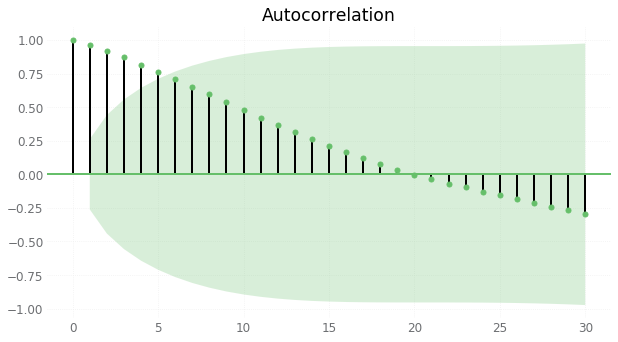

In [464]:
fig, ax = plt.subplots(figsize= (9,5))
plot_acf(y['male'], lags = 30, ax=ax)
plt.show()

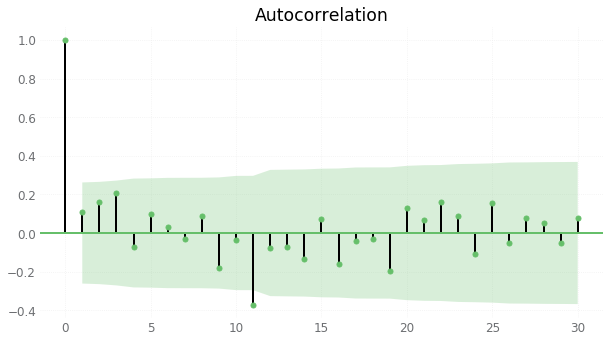

In [465]:
fig, ax = plt.subplots(figsize= (9,5))
plot_acf(y['male_d1'], lags = 30, ax=ax)
plt.show()

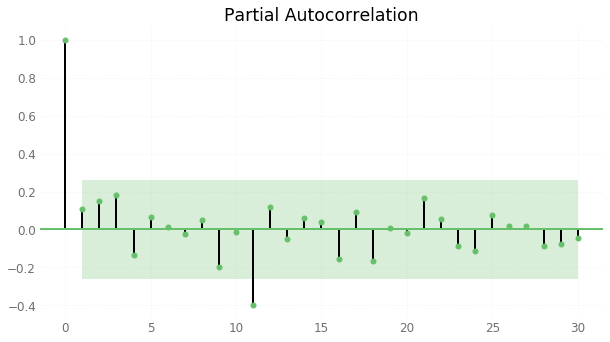

In [470]:
fig, ax = plt.subplots(figsize= (9,5))
plot_pacf(y['male_d1'], lags = 30, ax=ax)
plt.show()

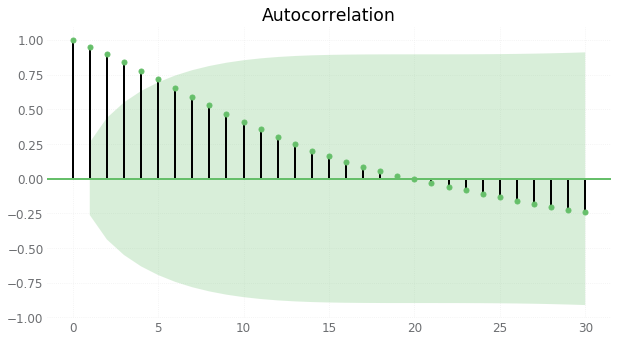

In [466]:
fig, ax = plt.subplots(figsize= (9,5))
plot_acf(y['female'], lags = 30, ax=ax)
plt.show()

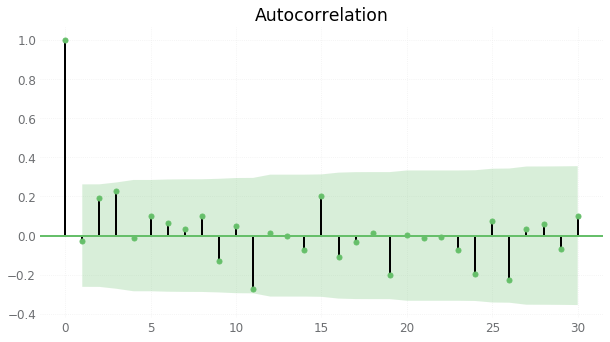

In [467]:
fig, ax = plt.subplots(figsize= (9,5))
plot_acf(y['female_d1'], lags = 30, ax=ax)
plt.show()

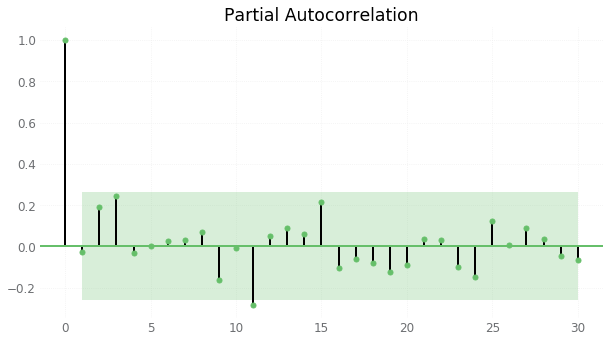

In [468]:
fig, ax = plt.subplots(figsize= (9,5))
plot_pacf(y['female_d1'], lags = 30, ax=ax)
plt.show()

In [471]:
cel['male_d11'] = cel['male_d1'].shift(11)           
cel['female_d11'] = cel['female_d1'].shift(11)


## Create ARMA model
---

Using the cells below, we can change the sex and which features to include in the model.  The features go into the ARMA model as exogenous variables.  The target is included as the endogenous variable.  

> For male, I got a train $R^2$ score of 99.1% and a test score of 97.8% using an ARMA(0,0) with features `hhi_ineq` (measure of income inequality), `lab_par_rate` (labor participation rate), `SP500`, `overweight`, `perc_inc_mil_spend` (percentage change in miliatary spending), `alc_per_capita` (alcohol consumption per capita)  

> The female model scored poorly (~80%) with the same model.  By dropping the `hhi_ineq`, `lab_par_rate`, and `perc_inc_mil_spend`, the female model improved with a training score of 99.1% and test score of 96.6%.  
> The male model performs poorly without these variables included.  

> The male model performed slightly better if we included the `obese` measure instead of the `overweight` measure, but the female model performed significantly worse with this change.

In [491]:
sex = 'male'

X1 = X[[
#     'gdp_q1',
#     'hhi_40ptl',
#     'hhi_95ptl',
     'hhi_ineq',
      'lab_par_rate',
#     'military_spend',
#     'military_spend_pct_gdp',
#     'inflation',
     'SP500',
#     '3mo_UST',
#     '10y_UST',
#     'gdp_per_cap',
#     'gpd_incr',
#     'ins_rate',
     'overweight',
#     'obese',
#     'severe_obese',
#     'military_spend_per_capita',
     'perc_inc_mil_spend',
     'alc_per_capita',
#     'adult_tob_perc'
]].copy()
#X1 = X[['hhi_ineq','SP500','gdp_per_cap','ins_rate','overweight','severe_obese','military_spend_per_capita','alc_per_capita','adult_tob_perc']].copy()
#X1 = X[['SP500','gdp_per_cap','ins_rate','overweight','severe_obese','military_spend_per_capita','alc_per_capita','adult_tob_perc']].copy()
X1['shift_d'] = cel[sex+'_d11']['1960':'2015'].copy()

ym = y[sex+'_d1']

Xtrain = X1['1960':'1995']
Xtest = X1['1996':'2015']
ytrain = ym[0:len(Xtrain)]
ytest = ym[len(Xtrain):]

arma = ARMA(endog = ytrain, exog=Xtrain, dates=Xtrain.index, order=(0,0), freq='A').fit()

yhat = arma.predict(ytrain.index[0],ytrain.index[-1], exog = Xtrain)    # predicts t-1 differences
total_pred = y[sex].shift()[1:len(Xtrain)]+ yhat[1:]                    # adds differences to t-1 for CEL pred
print('r2 train: ', r2_score(y[sex][1:len(Xtrain)],total_pred))

yhat = arma.predict(ytest.index[0], ytest.index[-1], exog=Xtest)
total_pred = y[sex].shift()[len(Xtrain):len(y)]+ yhat
print('r2 test: ', r2_score(y[sex][len(Xtrain):len(y)],total_pred))





r2 train:  0.991369749455433
r2 test:  0.9783868731990498


### In reality the endogenous variables added very little to the overall model.  Looking at a model without endogenous variables provided a test score that was just slightly lower than the model above.

In [492]:
arma = ARMA(endog = ytrain, exog=None, dates=Xtrain.index, order=(0,0), freq='A').fit()
yhat = arma.predict(ytest.index[0], ytest.index[-1], exog=None)
total_pred = y[sex].shift()[len(Xtrain):len(y)]+ yhat
r2_score(y[sex][len(Xtrain):len(y)],total_pred)

0.9746101140196913